In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

In [ ]:
import numpy as np
# import cupy
import copy

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import output

def beep():
    output.eval_js('new Audio("https://soundeffect-lab.info/sound/anime/mp3/kotsudumi1.mp3").play()')

# Reservoir-based Convolution1D

In [ ]:
class Reservoir(object):
    def __init__(self, i_size, r_size, i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5):
        self.w_i = xp.random.uniform(-i_coef, i_coef, (r_size, i_size)).astype(xp.float32)

        # self.w_r = np.random.normal(0, 1, (r_size, r_size)).astype(np.float32)
        self.w_r = np.random.uniform(-1, 1, (r_size * r_size, )).astype(np.float32)
        self.w_r[0:int(r_size * r_size * (1 - sparse))] = 0
        np.random.shuffle(self.w_r)
        self.w_r = self.w_r.reshape(r_size, r_size)
        self.w_r = self.w_r / max(abs(np.linalg.eig(self.w_r)[0])) * r_coef
        self.w_r = xp.array(self.w_r)

        self.leak = leak


    def reset(self, batch):
        self.x = xp.zeros((batch, self.w_r.shape[0]), dtype=xp.float32)


    def __call__(self, u):
        if not u.shape[0] == self.x.shape[0]:
            print('different batchsize')
            print('required:', self.x.shape[0])
            print('actual:', u.shape[0])

        self.x = xp.tanh((1 - self.leak) * self.x + self.leak * (u.dot(self.w_i.T) + self.x.dot(self.w_r.T)), dtype=xp.float32)

        return self.x


    # wrapper function
    def reset_and_call(self, us):
        self.reset(batch=us.shape[1])

        # us: (T, B, C)
        for u in us:
            x = self.__call__(u)

        # x: (B, R) = (B, C)
        return copy.deepcopy(x)

In [ ]:
class ReservoirBasedConvolution1D(object):
    def __init__(self, k_size, stride, padding, in_ch, num_reservoir, num_node, sparse, i_coef=1.0, r_coef=0.999):
        leaks = np.linspace(0.1, 0.9, num_reservoir)
        self.res = [Reservoir(in_ch, num_node, i_coef=i_coef, r_coef=r_coef, sparse=sparse, leak=l) for l in leaks]

        self.k_size = k_size
        self.stride = stride
        self.padding = padding


    def __call__(self, x):
        # array 2 aois
        aois, num_col = self._array2aois(x, self.k_size, self.stride, self.padding)

        # convolution
        hs = []
        for res in self.res:
            h = res.reset_and_call(aois)
            hs.append(h)

        # (N*B, C) -> (N, B, C) = (W, B, C)
        hs = xp.concatenate(hs, axis=1)
        hs = hs.reshape(num_col, -1, hs.shape[1])

        # convs 2 image: (W, B, C) -> (B, C, W)
        images = xp.asarray(hs)
        images = xp.rollaxis(images, 0, 3)

        return images


    def _array2aois(self, x, k_size, stride, padding):
        # x (B, C, W)

        # padding
        x_pad = xp.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding), dtype=xp.float32)
        x_pad[:, :, padding:padding + x.shape[2]] = x

        # areas of interest
        aois = []
        num_col = (x_pad.shape[2] - k_size) // stride + 1
        for w in range(0, x_pad.shape[2] - k_size + 1, stride):
            aoi = x_pad[:, :, w:w+k_size]

            # (B, C, W) -> (W, B, C) = (T, B, C)
            aoi = xp.rollaxis(aoi, 2, 0)
            aois.append(aoi)

        # (T, N*B, C)
        aois = xp.concatenate(aois, axis=1)
        return aois, num_col

In [ ]:
def max_pool1d(x, k_size, stride, padding=0):
    # padding
    x_pad = xp.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding), dtype=xp.float32)
    x_pad[:, :, padding:padding + x.shape[2]] = x

    # aois
    aois = []
    num_col = (x_pad.shape[2] - k_size) // stride + 1
    for w in range(0, x_pad.shape[2] - k_size + 1, stride):
        aoi = x_pad[:, :, w:w+k_size]
        aois.append(aoi)

    # pooling
    aois = xp.array(aois)
    pools = xp.max(aois, axis=3)

    # (W, B, C) -> (B, C, W)
    pools = xp.array(pools)
    pools = xp.rollaxis(pools, 0, 3)

    return pools


def global_ave_pool1d(x):
    # (B, C, H, W) -> (B, C)
    x = xp.mean(x, axis=2)

    return x

In [ ]:
def ridge_regression(x, t, norm=1.0):
    array = x.T.dot(x)
    array = array + norm * xp.eye(x.shape[1])
    array = xp.linalg.inv(array)
    array = array.dot(x.T)
    array = array.dot(t)

    return array.T

# FSDD

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4240, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 4240 (delta 14), reused 8 (delta 8), pack-reused 4212
Receiving objects: 100% (4240/4240), 30.38 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
from scipy.io.wavfile import read
import os

root_path = '/content/free-spoken-digit-dataset/recordings'
filenames = os.listdir(root_path)

person_list = ['jackson', 'nicolas', 'theo', 'yweweler', 'george', 'lucas']

x_train = []
x_test = []
t_digit_train = []
t_digit_test = []
t_person_train = []
t_person_test = []

for filename in filenames:
    digit, person, id = filename.split('.')[0].split('_')
    sr, data = read(os.path.join(root_path, filename))

    # test
    if int(id) < 5:
        x_test.append(data)
        t_digit_test.append(int(digit))
        t_person_test.append(person_list.index(person))

    # train
    else:
        x_train.append(data)
        t_digit_train.append(int(digit))
        t_person_train.append(person_list.index(person))

In [ ]:
LENGTH = 6000

x_train_array = []
for x in x_train:
    zero = np.zeros((1, LENGTH), dtype=np.float32)
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_train_array.append(zero)

x_test_array = []
for x in x_test:
    zero = np.zeros((1, LENGTH), dtype=np.float32)
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_test_array.append(zero)

x_train_array = np.concatenate(x_train_array, axis=0)
x_test_array = np.concatenate(x_test_array, axis=0)

In [ ]:
np.savez('fsdd.npz', x_train=x_train_array, x_test=x_test_array, t_digit_train=t_digit_train, t_digit_test=t_digit_test, t_person_train=t_person_train, t_person_test=t_person_test)

In [ ]:
fsdd = np.load('fsdd.npz')
x_train = fsdd['x_train'] / 32768.0
x_test = fsdd['x_test'] / 32768.0
t_digit_train = fsdd['t_digit_train']
t_digit_test = fsdd['t_digit_test']
t_person_train = fsdd['t_person_train']
t_person_test = fsdd['t_person_test']

print(x_train.shape)
print(x_test.shape)
print(t_digit_train.shape)
print(t_digit_test.shape)
print(t_person_train.shape)
print(t_person_test.shape)

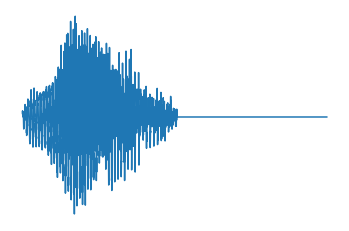

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x_train_array[1])
plt.axis('off')
plt.show()

# FSDD + Lyon

In [ ]:
!pip install lyon

In [ ]:
import lyon.calc
calc = lyon.calc.LyonCalc()

In [ ]:
x_train_lyon = []
for x in x_train_array:
    x = x.astype(np.float64)
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=60)
    x_train_lyon.append(coch)

x_test_lyon = []
for x in x_test_array:
    x = x.astype(np.float64)
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=60)
    x_test_lyon.append(coch)

x_train_lyon = np.asarray(x_train_lyon)
x_test_lyon = np.asarray(x_test_lyon)

In [ ]:
np.savez('fsdd_lyon.npz', x_train=x_train_lyon, x_test=x_test_lyon, t_digit_train=t_digit_train, t_digit_test=t_digit_test, t_person_train=t_person_train, t_person_test=t_person_test)

In [ ]:
fsdd_lyon = np.load('/content/drive/MyDrive/Kyutech/nedo/reservoir_based_convolution/fsdd_lyon.npz')
x_train_lyon = np.rollaxis(fsdd_lyon['x_train'], 1, 3)
x_test_lyon = np.rollaxis(fsdd_lyon['x_test'], 1, 3)
t_digit_train = fsdd_lyon['t_digit_train']
t_digit_test = fsdd_lyon['t_digit_test']
t_person_train = fsdd_lyon['t_person_train']
t_person_test = fsdd_lyon['t_person_test']

print(x_train_lyon.shape)
print(x_test_lyon.shape)
print(t_digit_train.shape)
print(t_digit_test.shape)
print(t_person_train.shape)
print(t_person_test.shape)

(2700, 64, 100)
(300, 64, 100)
(2700,)
(300,)
(2700,)
(300,)


In [ ]:
x_train_lyon[1].shape

(64, 100)

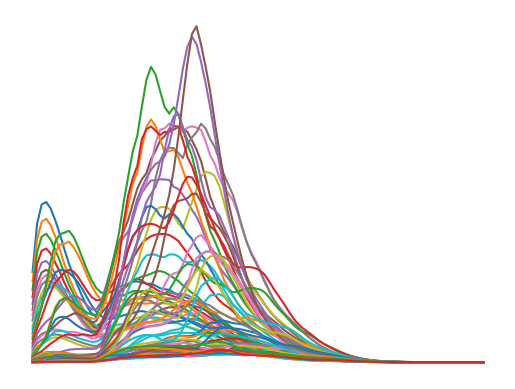

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.rollaxis(x_train_lyon[0], 0, 2))
plt.axis('off')
plt.show()

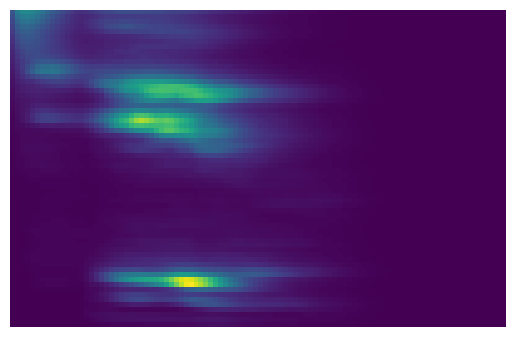

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_train_lyon[0])
plt.axis('off')
plt.show()

# Train and Test

In [ ]:
xp = np

In [ ]:
# conv1 = ReservoirBasedConvolution1D(k_size=5, stride=1, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)    # max_pool1d(h, k_size=4, stride=4)     86.00 / 94.66
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=1, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     88.33 / 94.33
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=2, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     85.66 / 96.33
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     84.33 / 97.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1)   # max_pool1d(h, k_size=4, stride=4)     86.33 / 96.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.5)   # max_pool1d(h, k_size=4, stride=4)     83.00 / 95.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.8)   # max_pool1d(h, k_size=4, stride=4)     86.67 / 95.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9)   # max_pool1d(h, k_size=2, stride=2)     89.33 / 93.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     91.00 / 95.33 <-
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=1.0)   # max_pool1d(h, k_size=4, stride=4)     85.67 / 95.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=50, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     90.67 / 95.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=10, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)  # max_pool1d(h, k_size=4, stride=4)     80.67 / 92.00
# conv1 = ReservoirBasedConvolution1D(k_size=20, stride=1, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     85.67 / 95.33
# conv1 = ReservoirBasedConvolution1D(k_size=20, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)   # max_pool1d(h, k_size=4, stride=4)     88.33 / 95.33
# conv1 = ReservoirBasedConvolution1D(k_size=20, stride=10, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)  # max_pool1d(h, k_size=4, stride=4)     82.00 / 94.00
# conv1 = ReservoirBasedConvolution1D(k_size=20, stride=20, padding=0, in_ch=64, num_reservoir=5, num_node=20, sparse=0.9)  # max_pool1d(h, k_size=4, stride=4)     76.33 / 89.00


# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=10.0) # max_pool1d(h, k_size=4, stride=4) 93.00 / 96.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=15.0) # max_pool1d(h, k_size=4, stride=4) 93.33 / 97.33
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=20.0) # max_pool1d(h, k_size=4, stride=4) 94.67 / 98.30
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=25.0) # max_pool1d(h, k_size=4, stride=4) 93.67 / 98.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0) # max_pool1d(h, k_size=4, stride=4) 96.33 / 98.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0) # max_pool1d(h, k_size=4, stride=2) 95.67 / 99.00
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0) # max_pool1d(h, k_size=2, stride=2) 95.33 / 98.33
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.2, i_coef=30.0) # max_pool1d(h, k_size=4, stride=4) 94.67 / 98.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.8, i_coef=30.0) # max_pool1d(h, k_size=4, stride=4) 94.67 / 98.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=30.0) # max_pool1d(h, k_size=4, stride=4) 96.33 / 97.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=1.0, i_coef=30.0) # max_pool1d(h, k_size=4, stride=4) 95.33 / 98.67
# conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.9, i_coef=40.0) # max_pool1d(h, k_size=4, stride=4) 94.67 / 98.33

#conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0, r_coef=1.2) # max_pool1d(h, k_size=4, stride=4) 96/98
#conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0, r_coef=1.3) # max_pool1d(h, k_size=4, stride=4) 96/98.67
conv1 = ReservoirBasedConvolution1D(k_size=10, stride=5, padding=0, in_ch=64, num_reservoir=5, num_node=30, sparse=0.1, i_coef=30.0, r_coef=3.0)
w_o = xp.zeros((10, 601), dtype=xp.float32)

In [ ]:
plt.rcParams["figure.figsize"]

[6.4, 4.8]

In [ ]:
from pathlib import Path

for fontlist in Path("/root/.cache/matplotlib/").glob("*.json"):
    with open(fontlist) as file:
        for line in file:
            if '"name"' in line:
                print(line.rstrip())

      "name": "Helvetica",
      "name": "Helvetica",
      "name": "ITC Zapf Chancery",
      "name": "New Century Schoolbook",
      "name": "ITC Zapf Dingbats",
      "name": "Courier",
      "name": "ITC Bookman",
      "name": "Times",
      "name": "ITC Bookman",
      "name": "Helvetica",
      "name": "ITC Bookman",
      "name": "Helvetica",
      "name": "ITC Bookman",
      "name": "Helvetica",
      "name": "Palatino",
      "name": "Courier",
      "name": "Computer Modern",
      "name": "Palatino",
      "name": "Helvetica",
      "name": "Symbol",
      "name": "New Century Schoolbook",
      "name": "Utopia",
      "name": "Times",
      "name": "Times",
      "name": "Palatino",
      "name": "Computer Modern",
      "name": "Courier",
      "name": "Times",
      "name": "Courier",
      "name": "Times",
      "name": "Courier",
      "name": "Utopia",
      "name": "Utopia",
      "name": "Computer Modern",
      "name": "Courier",
      "name": "ITC Avant Garde Got

In [ ]:
# import matplotlib as mpl

plt.rcParams["font.family"] = 'serif'

In [ ]:
def forward(x):
    h1 = conv1(x)

    print(h1.shape)
    # plt.plot(h1[0][0])
    # plt.plot(h1[0][140])
    plt.imshow(h1[0].repeat(4, axis=1), origin='lower')
    plt.tick_params(labelbottom=False, labelleft=True, labelright=False, labeltop=False)
    plt.xlabel('Time')
    plt.ylabel('Channel')
    plt.tick_params(labelsize=10)
    plt.colorbar()
    plt.rcParams["figure.figsize"] = [6.4, 4.8]
    import sys; sys.exit()

    h2 = max_pool1d(h1, k_size=4, stride=4)

    h3 = h2.reshape(h2.shape[0], -1)
    h_pad = xp.ones((h3.shape[0], h3.shape[1] + 1), dtype=xp.float32)
    h_pad[:, 0:-1] = h3

    #print(h_pad.shape)

    y = h_pad.dot(w_o.T)
    return y, h_pad, (h1, h2)

(2700, 150, 19)


SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


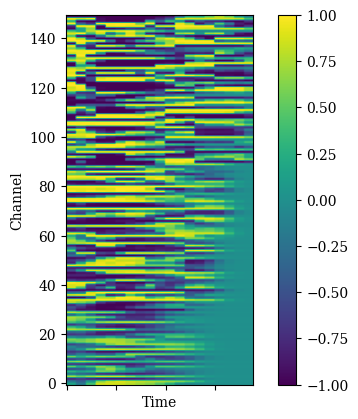

In [ ]:
BATCH = 2700

#####
import time
s = time.time()
#####

hs = []
for i in range(0, x_train_lyon.shape[0], BATCH):
    x = xp.array(x_train_lyon[i:i+BATCH].reshape(BATCH, 64, -1)).astype(xp.float32)
    _, h, (h1, h2) = forward(x)
    hs.append(h)

    # if i % 500 == 0:
    #   print(i)

hs = xp.concatenate(hs, axis=0)

#####
e = time.time() - s
print(e)
#####

In [ ]:
array = [
5.023207426071167 + 0.09493303298950195,
5.079733610153198 + 0.10019898414611816,
5.182573318481445 + 0.08838319778442383,
5.160366773605347 + 0.09034466743469238,
5.096548080444336 + 0.0878598690032959,
5.055620431900024 + 0.1114652156829834,
5.153764963150024 + 0.12370467185974121,
5.172405242919922 + 0.10236597061157227,
5.152272701263428 + 0.08847212791442871,
5.001447916030884 + 0.08812808990478516
]

print(np.mean(array))
print(np.std(array))

5.205379629135132
0.06418185374216956


In [ ]:
array = [
5.217101812362671 + 0.0916292667388916,
5.185964584350586 + 0.09998059272766113,
5.3501296043396 + 0.09180068969726562,
5.498060941696167 + 0.10240459442138672,
5.279855966567993 + 0.08510589599609375
]

print(np.mean(array))
print(np.std(array))

5.400406789779663
0.11358692087379393


### debug

(64, 100)


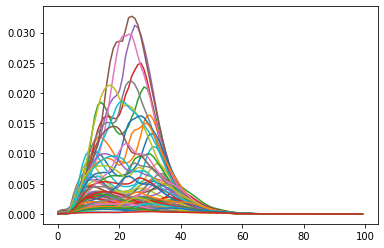

In [ ]:
import matplotlib.pyplot as plt

print(x[0].shape)
plt.plot(np.rollaxis(cupy.asnumpy(x[0]), 1, 0))
plt.show()

(150, 19)


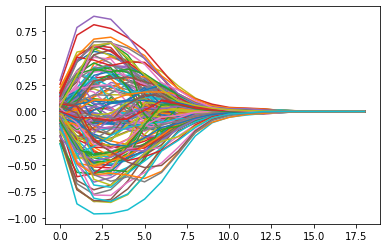

In [ ]:
print(h1[0].shape)
plt.plot(np.rollaxis(cupy.asnumpy(h1[0]), 1, 0))
plt.show()

(150, 9)


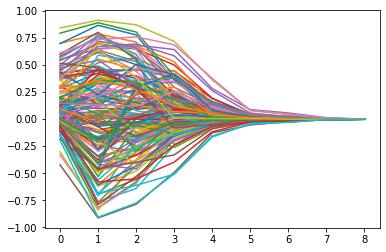

In [ ]:
print(h2[0].shape)
plt.plot(np.rollaxis(cupy.asnumpy(h2[0]), 1, 0))
plt.show()

## digit: 91.00%

In [ ]:
#####
import time
s = time.time()
#####

ts = xp.eye(10)[xp.array(t_digit_train, dtype=xp.int32)]
w_o = ridge_regression(hs, ts, norm=1.0)

#####
e = time.time() - s
print(e)
#####

# print(np.max(cupy.asnumpy(w_o)))
# print(np.min(cupy.asnumpy(w_o)))

0.08637762069702148


In [ ]:
print('max', np.max(w_o))
print('min', np.min(w_o))

max 0.5517023169519792
min -0.2868283826757343


In [ ]:
BATCH = 300

preds = []

for i in range(0, x_test_lyon.shape[0], BATCH):
    x = xp.array(x_test_lyon[i:i+BATCH].reshape(BATCH, 64, -1)).astype(xp.float32)
    y, _, _ = forward(x)
    pred = xp.argmax(y, axis=1)
    preds += pred.tolist()

accuracy = np.sum(np.equal(preds, np.array(t_digit_test, dtype=np.int32))) / x_test_lyon.shape[0]
print(accuracy)

0.9566666666666667


In [ ]:
array = [
0.9533333333333334,
0.95,
0.9566666666666667,
0.9566666666666667,
0.96,
0.95,
0.9466666666666667,
0.95,
0.9733333333333334,
0.9566666666666667
]

print(np.mean(array))
print(np.std(array))

0.9553333333333333
0.007180219742846026


## person: 95.33%

In [ ]:
#####
import time
s = time.time()
#####

ts = xp.eye(6)[xp.array(t_person_train, dtype=xp.int32)]
w_o = ridge_regression(hs, ts, norm=1.0)

#####
e = time.time() - s
print(e)
#####

# print(np.max(cupy.asnumpy(w_o)))
# print(np.min(cupy.asnumpy(w_o)))

0.41579604148864746


In [ ]:
print('max', np.max(w_o))
print('min', np.min(w_o))

max 0.7208716336471191
min -0.3823727000163392


In [ ]:
0.7208716336471191 / 0.5517023169519792

1.3066315139471574

In [ ]:
preds = []
BATCH = 300
for i in range(0, x_test_lyon.shape[0], BATCH):
    x = xp.array(x_test_lyon[i:i+BATCH].reshape(BATCH, 64, -1)).astype(xp.float32)
    y, _, _ = forward(x)
    pred = xp.argmax(y, axis=1)
    preds += pred.tolist()

accuracy = np.sum(np.equal(preds, np.array(t_person_test, dtype=np.int32))) / x_test_lyon.shape[0]
print(accuracy)

0.9866666666666667


In [ ]:
array = [
0.99,
0.9766666666666667,
0.9866666666666667,
0.97,
0.9866666666666667
]

print(np.mean(array))
print(np.std(array))

0.982
0.007483314773547893


# Comparison: ESN

In [ ]:
xp = np
reservoir = Reservoir(i_size=64, r_size=600, i_coef=30.0, r_coef=0.999, sparse=0.5, leak=0.5)

## digit: 82.67%

In [ ]:
# hs = []
# ts = []

# for x, t in zip(x_train_lyon, t_digit_train):
#     reservoir.reset(batch=1)

#     # (C, W) -> (W, C)
#     x = xp.asarray(x)
#     x = xp.rollaxis(x, 1, 0)
#     for u in x:
#         h = reservoir(u.reshape(1, -1))
#         hs.append(h)

#     ohv = xp.zeros((x.shape[0], 10), dtype=xp.float32)
#     ohv[:, t] = 1.0
#     ts.append(ohv)

# hs = xp.concatenate(hs, axis=0)
# ts = xp.concatenate(ts, axis=0)

In [ ]:
#####
import time
s = time.time()
#####

reservoir.reset(batch=2700)

x = xp.asarray(x_train_lyon)    # B, C, W
x = xp.rollaxis(x, 2, 0)        # W, B, C

hs = []
for u in x:
    h = reservoir(u)
    hs.append(h)

hs = xp.asarray(hs)             # W, B, O
hs = xp.rollaxis(hs, 1, 0)      # B, W, O
hs = hs.reshape(hs.shape[0] * hs.shape[1], -1)

ts = []
for t in zip(t_digit_train):
    ohv = xp.zeros((x.shape[0], 10), dtype=xp.float32)
    ohv[:, t] = 1.0
    ts.append(ohv)

ts = xp.concatenate(ts, axis=0)

#####
e = time.time() - s
print(e)
#####

11.213968753814697


In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(hs[0:100, 0:20])
# plt.show()

In [ ]:
import time
s = time.time()

w_o = ridge_regression(hs, ts, norm=1.0)

e = time.time() - s
print(e)

5.125686883926392


In [ ]:
array = [
10.762507677078247 + 5.148868799209595,
12.459873676300049 + 5.137722015380859,
11.175812005996704 + 5.18598198890686,
11.328673601150513 + 5.113004684448242,
11.190261125564575 + 5.105655193328857,
10.38264012336731 + 5.162513732910156,
11.079195976257324 + 5.108962059020996,
11.157110929489136 + 5.137025833129883,
11.097359418869019 + 5.043973445892334,
11.213968753814697 + 5.125686883926392
]

print(np.mean(array))
print(np.std(array))

16.311679792404174
0.49662964977341517


In [ ]:
# i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5
# R=100  (norm=0.1): 71.67%, (norm=1.0): 71.33%, (norm=10.0): 71.33%
# R=500  (norm=0.1): 81.67%, (norm=1.0): 81.00%, (norm=10.0): 79.33%
# R=1000 (norm=0.1): 82.67%, (norm=1.0): 81.33%, (norm=10.0): 79.33%

# i_coef=10.0, r_coef=0.999, sparse=0.5, leak=0.5
# R=600  (norm=10.0): 89.00%

# i_coef=20.0, r_coef=0.999, sparse=0.5, leak=0.5
# R=600  (norm=10.0): 91.33%

# i_coef=20.0, r_coef=0.999, sparse=0.5, leak=0.5
# R=600  (norm=10.0): 93.33%

correct = 0.0
count = 0.0

for x, t in zip(x_test_lyon, t_digit_test):
    reservoir.reset(batch=1)

    # (C, W) -> (W, C)
    x = xp.asarray(x)
    x = xp.rollaxis(x, 1, 0)

    ys = []
    for u in x:
        h = reservoir(u.reshape(1, -1))
        y = h.dot(w_o.T)
        ys.append(y)

    ys = xp.concatenate(ys, axis=0)
    pred = xp.argmax(xp.mean(ys, axis=0))

    if pred == t:
        correct += 1.0
    count += 1.0

print(correct / count)

0.91


In [ ]:
array = [
0.8966666666666666,
0.91,
0.9133333333333333,
0.9166666666666666,
0.9233333333333333,
0.92,
0.93,
0.92,
0.91,
0.91
]

print(np.mean(array))
print(np.std(array))

0.915
0.008724168218868287


## person: 90.67%

In [ ]:
# hs = []
# ts = []

# for x, t in zip(x_train_lyon, t_person_train):
#     reservoir.reset(batch=1)

#     # (C, W) -> (W, C)
#     x = xp.asarray(x)
#     x = xp.rollaxis(x, 1, 0)
#     for u in x:
#         h = reservoir(u.reshape(1, -1))
#         hs.append(h)

#     ohv = xp.zeros((x.shape[0], 6), dtype=xp.float32)
#     ohv[:, t] = 1.0
#     ts.append(ohv)

# hs = xp.concatenate(hs, axis=0)
# ts = xp.concatenate(ts, axis=0)
# beep()

In [ ]:
#####
import time
s = time.time()
#####

reservoir.reset(batch=2700)

x = xp.asarray(x_train_lyon)    # B, C, W
x = xp.rollaxis(x, 2, 0)        # W, B, C

hs = []
for u in x:
    h = reservoir(u)
    hs.append(h)

hs = xp.asarray(hs)             # W, B, O
hs = xp.rollaxis(hs, 1, 0)      # B, W, O
hs = hs.reshape(hs.shape[0] * hs.shape[1], -1)

ts = []
for t in zip(t_person_train):
    ohv = xp.zeros((x.shape[0], 6), dtype=xp.float32)
    ohv[:, t] = 1.0
    ts.append(ohv)

ts = xp.concatenate(ts, axis=0)

#####
e = time.time() - s
print(e)
#####

11.919543743133545


In [ ]:
import time
s = time.time()

w_o = ridge_regression(hs, ts, norm=1.0)

e = time.time() - s
print(e)

5.639448642730713


In [ ]:
array = [
11.323022603988647 + 6.524347543716431,
11.290214538574219 + 5.585218667984009,
13.959152460098267 + 5.673618793487549,
12.362993240356445 + 5.699830770492554,
11.919543743133545 + 5.639448642730713
]

print(np.mean(array))
print(np.std(array))

17.995478200912476
0.9112870733187857


In [ ]:
# i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5
# R=100  (norm=0.1): 66.00%, (norm=1.0): 66.00%, (norm=10.0): 65.00%
# R=500  (norm=0.1): 84.67%, (norm=1.0): 84.00%, (norm=10.0): 81.67%
# R=1000 (norm=0.1): 90.67%, (norm=1.0): 88.33%, (norm=10.0): 87.67%

correct = 0.0
count = 0.0

for x, t in zip(x_test_lyon, t_person_test):
    reservoir.reset(batch=1)

    # (C, W) -> (W, C)
    x = xp.asarray(x)
    x = xp.rollaxis(x, 1, 0)

    ys = []
    for u in x:
        h = reservoir(u.reshape(1, -1))
        y = h.dot(w_o.T)
        ys.append(y)

    ys = xp.concatenate(ys, axis=0)
    pred = xp.argmax(xp.mean(ys, axis=0))

    if pred == t:
        correct += 1.0
    count += 1.0

print(correct / count)

0.97


In [ ]:
array = [
0.9966666666666667,
0.98,
0.9966666666666667,
0.9833333333333333,
0.97
]

print(np.mean(array))
print(np.std(array))

0.9853333333333334
0.010241527663824839


# Comparison: SVM

In [ ]:
from sklearn import svm

## digit: 69.33%

In [ ]:
NORM = 1.0          # Regularization parameter
KERNEL = 'linear'   # linear: 69.33 / poly (3-deg): 43.00 / rbf: 66.00 / sigmoid: 40.33

svc = svm.SVC(C=NORM, kernel=KERNEL)

import time
s = time.time()
svc.fit(x_train_lyon.reshape(2700, 6400), t_digit_train)
e = time.time() - s
print(e)

25.46184253692627


In [ ]:
preds = svc.predict(x_test_lyon.reshape(300, 6400))
print(np.sum(preds == t_digit_test), np.sum(preds == t_digit_test) / len(preds))

208 0.6933333333333334


In [ ]:
array = [
    25.04184889793396,
    25.415222644805908,
    26.046390295028687,
    24.80177664756775,
    25.46184253692627
]
print(np.mean(array))
print(np.std(array))

25.353416204452515
0.42359645491056386


## person: 95.33%

In [ ]:
NORM = 1.0          # Regularization parameter
KERNEL = 'linear'   # linear: 95.33 / poly (3-deg): 66.00 / rbf: 92.33 / sigmoid: 66.00

svc = svm.SVC(C=NORM, kernel=KERNEL)

s = time.time()
svc.fit(x_train_lyon.reshape(2700, 6400), t_person_train)
e = time.time() - s
print(e)

10.95464038848877


In [ ]:
array = [
    10.635550737380981,
    11.39727520942688,
    11.032512903213501,
    10.97822117805481,
    10.95464038848877
]
print(np.mean(array))
print(np.std(array))

10.999640083312988
0.24258570018273964


In [ ]:
preds = svc.predict(x_test_lyon.reshape(300, 6400))
print(np.sum(preds == t_person_test), np.sum(preds == t_person_test) / len(preds))

286 0.9533333333333334


# Comparison: RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## digit: 96.67%

In [ ]:
N = 50              # The number of trees in the forest.
                    # N=50 : 96.33
                    # N=100: 96.67
                    # N=200: 95.67

rf = RandomForestClassifier(n_estimators=N)

s = time.time()

rf.fit(x_train_lyon.reshape(2700, 6400), t_digit_train)

e = time.time() - s
print(e)

7.714765787124634


In [ ]:
array = [
15.061578750610352,
15.080294609069824,
15.056862115859985,
15.29823088645935,
15.283113241195679,
15.272452116012573,
15.037270307540894,
15.05522871017456,
15.12823486328125,
15.530794382095337
]
print(np.mean(array))
print(np.std(array))

15.18040599822998
0.15295760588927118


In [ ]:
array = [
7.7509002685546875,
7.598536729812622,
7.676716327667236,
7.658264398574829,
7.535037517547607,
7.686023235321045,
7.657484292984009,
7.747622728347778,
7.686918020248413,
7.683145761489868
]

print(np.mean(array))
print(np.std(array))

7.668064928054809
0.06075345082734935


In [ ]:
preds = rf.predict(x_test_lyon.reshape(300, 6400))
print(np.sum(preds == t_digit_test), np.sum(preds == t_digit_test) / len(preds))

289 0.9633333333333334


In [ ]:
# 100
array = [
0.9766666666666667,
0.9633333333333334,
0.9633333333333334,
0.9633333333333334,
0.96,
0.95,
0.96,
0.95,
0.9666666666666667,
0.96
]
print(np.mean(array))
print(np.std(array))

0.9613333333333334
0.007333333333333357


In [ ]:
array = [
0.9466666666666667,
0.9566666666666667,
0.9466666666666667,
0.9566666666666667,
0.95,
0.9566666666666667,
0.9433333333333334,
0.9533333333333334,
0.9533333333333334,
0.9633333333333334
]

print(np.mean(array))
print(np.std(array))

0.9526666666666668
0.005734883511361759


## person: 99.33%

In [ ]:
N = 100           # The number of trees in the forest.
                    # N=50 : 98.67
                    # N=100: 98.67
                    # N=200: 99.33
                    # N=400: 99.33

rf = RandomForestClassifier(n_estimators=N)

s = time.time()
rf.fit(x_train_lyon.reshape(2700, 6400), t_person_train)
e = time.time() - s
print(e)

12.778001070022583


In [ ]:
# N=50
array = [
6.94230318069458,
6.4357523918151855,
6.410868406295776,
6.524596691131592,
6.4849371910095215
]
print(np.mean(array))
print(np.std(array))

6.559691572189331
0.19530528220373486


In [ ]:
# N=100
array = [
14.000087261199951,
12.936708927154541,
12.977986574172974,
13.03008222579956,
13.381697416305542
]
print(np.mean(array))
print(np.std(array))

13.265312480926514
0.39982725671956487


In [ ]:
preds = rf.predict(x_test_lyon.reshape(300, 6400))
print(np.sum(preds == t_person_test), np.sum(preds == t_person_test) / len(preds))

297 0.99


In [ ]:
# N=50
array = [
0.99,
0.99,
0.99,
0.99,
0.9933333333333333
]
print(np.mean(array))
print(np.std(array))

0.9906666666666666
0.0013333333333333196


In [ ]:
# N=100
array = [
0.99,
0.9866666666666667,
0.9866666666666667,
0.99,
0.99
]
print(np.mean(array))
print(np.std(array))

0.9886666666666667
0.0016329931618554354
